<center>
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800">

# Основы глубинного обучения: домашнее задание 4
</center>

**ФИО:** Салман Ясмина

**Забавный факт о себе:** На этой неделе у меня дедлайны по 5 домашкам ха-ха

## Общая информация

__Дата выдачи:__ 26.11.2024

__Мягкий дедлайн:__ 23:59MSK 10.12.2024

__Жесткий дедлайн:__ 23:59MSK 13.12.2024

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов + 2 бонусных балла.

**Дисклеймер:** Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). Также помните, что простое копирование чужого кода не является самостоятельной работой.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Описание данных

Данные можно [скачать с гугл-диска.](https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing) Если вы делаете задание в колабе, то строчки ниже сами скачают вам данные.



In [3]:
import gdown

url = "https://drive.google.com/drive/folders/1lGK5Inmx-aQr2DVs0ZHRwiNSE9r7umki?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/news_data/ria_news.tsv',
 '/content/news_data/vk_comments.tsv',
 '/content/news_data/vk_news.tsv']

В таблице `ria_news.tsv`  лежат данные о новостях, вышедших на сайте РИА-НОВОСТИ с 15 марта 2018 года по 31 декабря 2018 года.

- `href` - уникальный идентификатор новости (ссылка на неё)
- `date` - дата публикации новости
- `time` - время публикации новости
- `title` - заголовок новости
- `snippet` - краткое описание новости
- `text` - текст новости
- `category` - категория новости
- `keywords` - ключевые слова (подкатегории новости)
- `shows` - счётчик с числом просмотров новости на сайте (на момент парсинга)

In [4]:
df_ria = pd.read_csv('news_data/ria_news.tsv', sep='\t')
df_ria = df_ria[~df_ria.tags.isnull()]
print(df_ria.shape)
df_ria.head()

(201708, 9)


,href,date,time,title,snippet,text,category,tags,shows
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"Биньямин Нетаньяху, Израиль, В мире",728.0
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"Эммануэль Макрон, Франция, В мире",3086.0
2,/20181231/1548961337.html,2018-12-31,"31 декабря 2018, 23:12",Аарон Рэмзи проведет переговоры с пятью топ-кл...,"Полузащитник лондонского ""Арсенала"" Аарон Рэмз...","МОСКВА, 31 дек - РИА Новости. Полузащитник лон...",NaN,ФК Арсенал (Лондон),183.0
3,/20181231/1548961304.html,2018-12-31,"31 декабря 2018, 23:09",Гол Азмуна принес сборной Ирана победу над кат...,Футболисты сборной Ирана одержали победу над к...,"МОСКВА, 31 дек - РИА Новости. Футболисты сборн...",NaN,"Сердар Азмун, Сборная Ирана по футболу",78.0
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,Теннис,79.0


Многие новостные агенства поддерживают странички в социальных сетях. Они постят туда самые сочные сюжеты. В таблице `vk_news.tsv` лежат данные о новостях, которые РИА запостили ВКонтакте в период времени с  `2017-09-29 01:28:55` по `2019-02-01 23:13:17`.

- `id` - уникальный идентификатор поста
- `href` - ссылка на сайт (если она была указана в посте)
- `datetime` - дата и время публикации новости
- `title` - заголовок новости
- `text` - текст новости в социальной сети
- `likes` - число лайков под постом
- `comments` - число комментариев под постом

In [5]:
df_vk = pd.read_csv('news_data/vk_news.tsv', sep='\t')
df_vk['snippet'] = df_vk['text']
df_vk.drop('text', axis=1, inplace=True)
print(df_vk.shape)
df_vk.head()

(19928, 7)


,id,href,datetime,title,likes,comments,snippet
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN


В таблице `vk_comments.tsv` лежат комментарии к новостям.

- `id` - уникальный идентификатор комментария
- `post_id` - идентификатор новости, под которой был оставлен комментарий
- `datetime` - дата и время, когда был оставлен комментарий
- `text` - текст комментария
- `likes` - число лайков под комментарием

In [6]:
df_comments = pd.read_csv('news_data/vk_comments.tsv', sep='\t')
df_comments = df_comments[~df_comments.text.isnull()]
print(df_comments.shape)
df_comments.head()

<ipython-input-6-9f937a17e540>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments = pd.read_csv('news_data/vk_comments.tsv', sep='\t')


(2612629, 5)


,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


# А что надо сделать то?

В тетрадке вам предстоит сделать следующие шаги:

1. Обучить нейросеть предсказывать категорию новости
2. Построить предсказания для тех новостей, где мы ничего не знаем о категории
3. Использовать уже обученный для сентимент-анализа классификатор из библиотеки `hugging face` чтобы предсказать эмоциональную окраску каждого комментария
4. Провести аналитику по новостям, а именно построите топы из самых позитивных и негативных категорий и новостей

Для первого шага вам будет дан бэйзлайн. Если вы его прогоните, у вас получится базовая модель, которая даст некоторое качество решения задачи. Вам надо будет выяснить, насколько это качество оказалось хорошим, а затем внести в код некоторые улучшения.



## Часть 1: категоризация новостей (5 баллов + 1.8 бонусных)

Каждой новости в соотвествие поставлены ключевые слова. Будем считать, что эти ключевые слова — тематики новости. Нужно научиться предсказывать тематики по тексту новости. Готовые тематики у нас есть только по новостям с сайта. Они за 2018 год. По новостям из ВКонтакте у нас тематик нет. Мы собираемся их предсказать.

Новости, опубликованные ВКонтакте, отличаются от новостей с сайта тем, что у них есть только титул и короткое описание. Странно будет обучать нейросеть на длинных текстах, а потом использовать её на коротких описаниях. Мы не будем так делать. Мы попробуем обучить базовый вариант нейронной сети только на заголовках новостей. Все, кто захочет получить бонусные баллы, смогут попробовать добавить в нейросеть сниппеты (так назыают короткие описания новостей).

## 1.1 Подготовка таргета

Поработаем с таргетом. Мы будем предсказывать переменную `tags`. Давайте выясним скоько уникальных тегов существует.

In [7]:
df_ria['tags']

,tags
0,"Биньямин Нетаньяху, Израиль, В мире"
1,"Эммануэль Макрон, Франция, В мире"
2,ФК Арсенал (Лондон)
3,"Сердар Азмун, Сборная Ирана по футболу"
4,Теннис
...,...
201792,"Газпром, Вологодская область, Экономика"
201793,"Дело об отравлении Скрипалей, НАТО, Великобрит..."
201794,"Долгострой, Коммерческая недвижимость, Москва,..."
201795,"Великобритания, В мире"


In [8]:
from collections import Counter

# удалим все лишние пробелы и сделаем lowercase
df_ria['tags'] = (
    df_ria.tags.
    apply(lambda w: ','.join([item.strip() for item in  w.lower().split(',')]))
)

tags = ','.join(list(df_ria.tags.values))
tags_cnt = Counter(tags.split(','))

print(len(tags_cnt))
tags_cnt.most_common()[-20:]

13344


[('блог анны завершинской об автоспорте - блоги', 1),
 ('министерство транспорта рб', 1),
 ('министерство здравоохранения грузии', 1),
 ('палех', 1),
 ('юрий посохов (хореограф)', 1),
 ('мария александрова', 1),
 ('том бенсон', 1),
 ('абдул каюм кочай', 1),
 ('нуман куртулмуш', 1),
 ('mipim', 1),
 ('владимир попов', 1),
 ('брюно женезио', 1),
 ('роберт фицо', 1),
 ('сергей пашинский', 1),
 ('валерия гонтарева', 1),
 ('нововоронеж', 1),
 ('императорское православное палестинское общество', 1),
 ('event_poslanie_prezidenta_rf_federalnomu_sobraniju', 1),
 ('фхтр', 1),
 ('игорь честин', 1)]

Всего в выборке есть порядка 13 000 тэгов. Многие встречаются всего по разу. Давайте оставим в выборке только те тэги, которые встречаются более 30 раз.

In [9]:
target_tags = {tag for tag, cnt in tags_cnt.most_common() if cnt > 30}
len(target_tags)

1583

Закодируем теги для OHE.

In [10]:
tag2idx = dict(zip(target_tags, range(len(target_tags))))
idx2tag = {jtem: item for item,jtem in tag2idx.items()}

In [11]:
dict(list(idx2tag.items())[:10])

{0: 'археология',
 1: 'сбербанк',
 2: 'выборы в турции',
 3: 'республика татарстан',
 4: 'республика саха (якутия)',
 5: 'свердловская область',
 6: 'игорь никитин',
 7: 'совет по правам человека при президенте рф',
 8: 'национальный исследовательский ядерный университет "мифи"',
 9: 'иран'}

Почистим таргет от лишних тэгов.

In [12]:
df_ria['target_tags'] = (
    df_ria.tags.
    apply(lambda w: [tag2idx.get(item) for item in  w.split(',') if item in target_tags])
)

df_ria = df_ria[df_ria.target_tags.apply(len) > 0]
df_ria.shape

(201437, 10)

In [13]:
df_ria[['target_tags', 'tags']][5:10]

,target_tags,tags
7,"[1078, 1394]","таиланд,в мире"
8,"[1225, 826, 573, 978]","новый год—2019,дмитрий медведев,россия,общество"
9,"[1225, 1408, 1376]","новый год—2019,новый год,владимир путин"
10,"[571, 1394]","индонезия,в мире"
11,"[351, 1394]","амстердам,в мире"


In [14]:
idx2tag[803]

'мама'

In [15]:
df_ria.target_tags.values[5:7]

array([list([1078, 1394]), list([1225, 826, 573, 978])], dtype=object)

## 1.2 Подготовка текстов

Теперь займёмся предобработкой текстов. Приведём все слова к нижнему регистру и выбросим мусорные символы. В качестве токенов будем рассматривать отдельные слова.

Напомню, что мы пока что решили работать только с названиями статей. Поэтому вся предобработка применяется исключительно к ним. **Спойлер:** предобработку для сниппетов вы сделаете сами в первом же задании.

In [16]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
import re
from nltk.tokenize import word_tokenize

def normalise_text(text):
    text = text.lower()

    # сурово регулярками выкидываем мусорные символы
    text = re.sub('[^а-яa-z0-9 ]', '', text) #  удаляем все символы, которые не являются строчными буквами русского или английского алфавита, цифрами или пробелами
    return text.strip()

df_ria['title_clean'] = df_ria.title.apply(normalise_text)

word_cnt = Counter(word_tokenize(' '.join(df_ria.title_clean.values)))
len(word_cnt)

112178

In [18]:
word_cnt.most_common()[:10]

[('в', 127323),
 ('на', 44386),
 ('с', 26150),
 ('и', 21771),
 ('о', 19948),
 ('по', 17014),
 ('россии', 13494),
 ('не', 13483),
 ('сша', 9942),
 ('за', 9881)]

Давайте почистим словарь от стоп-слов и подготовим его к использованию внутри датасета. Мы будем с помощью словаря заменять слова на индексы. Добавим в словарь несколько специальных токенов для неизвестных слов и паддингов.

In [19]:
from nltk.corpus import stopwords

stops_ru = set(stopwords.words('russian'))
len(stops_ru)

151

In [20]:
vocabulary = {
    "#PAD#": 0, "#UNK#": 1
}

k = 2
for word, _ in word_cnt.most_common():
    if word not in stops_ru:
        vocabulary[word] = k
        k += 1

In [21]:
len(vocabulary)

112030

Завернём код для создания словаря в функцию.

In [22]:
def create_vocab(text, stops_ru=stops_ru):

    word_cnt = Counter(word_tokenize(text))
    vocabulary = {
        "#PAD#": 0, "#UNK#": 1
    }

    k = 2
    for word, _ in word_cnt.most_common():
        if word not in stops_ru:
            vocabulary[word] = k
            k += 1
    return vocabulary

__[0.5 балла] Задание 1:__

- Cделайте аналогичную предобработку титулов из таблички `df_vk`. Запишите получившийся результат в столбец `title_clean` по аналогии с таблицей `df_ria`.
- Сделайте для обеих таблиц предобработку колонок со сниппетами `snippet` и запишите получившийся результат в столбец `snippet_clean`. Все пропуски заполните токеном `"#UNKN"`.

In [23]:
df_vk['title_clean'] = df_vk.title.apply(normalise_text)
df_vk

,id,href,datetime,title,likes,comments,snippet,title_clean
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...
...,...,...,...,...,...,...,...,...
19923,17976905,/politics/20170929/1505812885.html,2017-09-29 03:51:03,"Политологи назвали губернаторов, которым грози...",141,114,NaN,политологи назвали губернаторов которым грозит...
19924,17976766,/politics/20170929/1505809314.html,2017-09-29 03:20:41,"Захарова рассказала, какую книгу подписывал Ла...",140,50,NaN,захарова рассказала какую книгу подписывал лав...
19925,17976601,/science/20170928/1505787196.html,2017-09-29 02:55:49,Современные люди появились более 300 тысяч лет...,202,69,NaN,современные люди появились более 300 тысяч лет...
19926,17976198,/world/20170929/1505810992.html,2017-09-29 02:00:09,В США ребенок устроил стрельбу,138,51,NaN,в сша ребенок устроил стрельбу


In [24]:
vocab_vk = create_vocab(text=' '.join(df_vk.title_clean.values))

In [25]:
def normalise_text_2(text):
    text = str(text).lower()

    # сурово регулярками выкидываем мусорные символы
    text = re.sub('[^а-яa-z0-9 ]', '', text) #  удаляем все символы, которые не являются строчными буквами русского или английского алфавита, цифрами или пробелами
    if text == 'nan':
        text = '#UNKN'
    return text.strip()

In [26]:
df_vk['snippet_clean'] = df_vk.snippet.apply(normalise_text_2)

df_ria['snippet_clean'] = df_ria.snippet.apply(normalise_text_2)

## 1.3 Поставка данных

Пересечение сайта и ВК по опубликованным новостям довольно маленькое. Мы обучаем модель на данных с сайта. Предсказания мы будем строить на данных из ВК. У этих данных разная природа. В ВК описание статей и заголовки короче. Модель может хорошо показать себя на данных с новостного сайта, но сильно просесть в качестве на данных из ВК.

Давайте сохраним пересечение в отдельную табличку, чтобы на нём можно было понять, насколько сильно деградирует модель.

In [27]:
ria_hrefs = set(df_ria.href.values)
vk_hrefs = set(df_vk.href.values)
test_hrefs = (vk_hrefs & ria_hrefs)

print('Размер отложенной выборки:', len(test_hrefs))

df = df_ria[~df_ria.href.isin(test_hrefs)]

Размер отложенной выборки: 1128


По странному совпадению (я правда не знаю почему) пересечение лежит в декабре. Мы будем его использовать как тестовую выборку.

In [28]:
df_ria[df_ria.href.isin(test_hrefs)].date.min(), df_ria[df_ria.href.isin(test_hrefs)].date.max()

('2018-12-06', '2018-12-31')

Предположим, что мы делим выборку на обучающую и тестовую случайно. За один и тот же промежуток времени может выйти довольно большое число новостей с одинаковым заголовком. Давайте представим себе, что в тесте и трэйне есть много статей про одно и то же событие. Модель научилась на обучающей выборке хорошо его тегировать. Остальные события модель тегирует намного хуже. Метрики на тестовой выборке высокие. В следующем месяце СМИ перестают освещать это событие, в потоке новостей совершенно другие новости. Качество модели резко проседает.

Чтобы не напороться на завышенные метрики, обычно выборку дробят на обучающую и тестовую по времени. Тогда статьи из теста будут имитировать поток новых новостей, освещающих новые события.

In [29]:
df.date.min(), df.date.max()

('2018-03-15', '2018-12-31')

__[0.5 балла] Задание 2:__ Разбейте выборку на обучающую, валидационную и тестовую. В тест возьмите весь декабрь. В валидацию октябрь и ноябрь.

In [30]:
df_ria['date'] = pd.to_datetime(df_ria['date'])

df_test = df_ria[df_ria['date'].dt.month == 12]
df_val = df_ria[(df_ria['date'].dt.month == 10) | (df_ria['date'].dt.month == 11)]
df_train = df_ria[~df_ria['date'].isin(df_test['date']) & ~df_ria['date'].isin(df_val['date'])]

In [31]:
df_test

,href,date,time,title,snippet,text,category,tags,shows,target_tags,title_clean,snippet_clean
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"биньямин нетаньяху,израиль,в мире",728.0,"[355, 446, 1394]",нетаньяху не собирается в отставку в случае пр...,премьерминистр израиля биньямин нетаньяху не н...
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"эммануэль макрон,франция,в мире",3086.0,"[944, 1112, 1394]",макрон в новогоднем обращении затронул тему ре...,результат реформ не может быть мгновенным заяв...
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,теннис,79.0,[735],пятая ракетка мира дель потро пропустит открыт...,аргентинский теннисист хуан мартин дель потро ...
5,/20181231/1548961218.html,2018-12-31,"31 декабря 2018, 23:06",СМИ: Кевину Спейси не разрешили отсутствовать ...,Суд в американском штате Массачусетс отверг хо...,"МОСКВА, 31 дек - РИА Новости. Суд в американск...",В мире,"кевин спейси,сша,в мире",2058.0,"[109, 1394]",сми кевину спейси не разрешили отсутствовать н...,суд в американском штате массачусетс отверг хо...
6,/20181231/1548961194.html,2018-12-31,"31 декабря 2018, 23:06","""Зимняя классика"" НХЛ в 2020 году пройдет в Да...","""Зимняя классика"" - матч регулярного чемпионат...","МОСКВА, 31 дек - РИА Новости. ""Зимняя классика...",NaN,"нхл,хоккей",89.0,"[750, 991]",зимняя классика нхл в 2020 году пройдет в далл...,зимняя классика матч регулярного чемпионата н...
...,...,...,...,...,...,...,...,...,...,...,...,...
21566,/20181201/1536926848.html,2018-12-01,"1 декабря 2018, 00:15",Путин предложил регулярно проводить встречи с ...,"РИА Новости, 01.12.2018","БУЭНОС-АЙРЕС, 1 дек — РИА Новости. Президент ...",В мире,"саммит g20 в аргентине,владимир путин,китай,ро...",791.0,"[380, 1376, 544, 573, 1018, 1394]",путин предложил регулярно проводить встречи с ...,риа новости 01122018
21567,/20181201/1536926678.html,2018-12-01,"1 декабря 2018, 00:11","Ракету ""Союз-ФГ"" с пилотируемым кораблем устан...","РИА Новости, 01.12.2018","МОСКВА, 1 дек — РИА Новости. Ракету ""Союз-ФГ""...",Наука,"союз-фг,байконур (космодром),россия,космос - р...",469.0,"[123, 573, 25, 479]",ракету союзфг с пилотируемым кораблем установя...,риа новости 01122018
21568,/20181201/1536848796.html,2018-12-01,"1 декабря 2018, 00:10",Эксперт: данные гостей нескольких отелей в Рос...,"РИА Новости, 01.12.2018","МОСКВА, 1 дек — РИА Новости. Данные постояльц...",Туризм,"россия,сша,новости - туризм,туризм",560.0,"[573, 109, 965, 92]",эксперт данные гостей нескольких отелей в росс...,риа новости 01122018
21569,/20181201/1536926612.html,2018-12-01,"1 декабря 2018, 00:08",Трамп и Мун Чжэ Ин: визит Ким Чен Ына в Сеул п...,"РИА Новости, 01.12.2018","МОСКВА, 1 дек — РИА Новости. Президент США До...",В мире,"мун чжэ ин,дональд трамп,ким чен ын,сша,южная ...",470.0,"[1090, 890, 1053, 109, 246, 927, 1394]",трамп и мун чжэ ин визит ким чен ына в сеул по...,риа новости 01122018


Сформируем отложенную выборку (пересечение ВКонтакте и РИА).

In [32]:
df_oob = df_vk[df_vk.href.isin(test_hrefs)][['href', 'title_clean']]

df_ria_oob = df_ria[df_ria.href.isin(test_hrefs)][['href', 'target_tags']]
df_oob = df_oob.set_index('href').join(df_ria_oob.set_index('href')).reset_index()
df_oob.head()

,href,title_clean,target_tags
0,/20181231/1548960744.html,митрополит рязанский раскритиковал иронию судьбы,[978]
1,/20181231/1548958617.html,на украине позавидовали стене на границе с крымом,"[582, 1394]"
2,/20181231/1548957394.html,в госдуме предложили отказаться от газа в жилы...,"[1084, 1084, 652, 573, 10]"
3,/20181231/1548954909.html,названы лучшие средства от похмелья,[978]
4,/20181231/1548957120.html,новогоднее поздравление порошенко разозлило по...,"[582, 1394]"


Напишем датасет для поставки данных в нейросеть.


In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NewsDataset(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):

       self.vocab = {word: idx  for word,idx in vocab.items() if idx < vocab_size}
       self.max_classes = max_classes
       self.y=self.target_ohe(target)
       self.X_title = self.create_text(title, max_title_len)

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i]*len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        return (self.X_title[idx, :], self.y[idx])


__[0.5 балла] Задание 3:__ Сейчас датасет умеет работать только с полем `title_clean`. Давайте сделаем этот датасет более многофукнциональным и добавим в него возможность добавить в обработку данных сниппет.

1. Внутри датасета `snippet` надо обработать точно также как и `title`.
2. Если `snippet=None`, датасет должен вернуть два объекта: `X_title, y`. В обратном случае датасет должен вернуть три объекта.

**Важно:** Весь код ниже работает сейчас без сниппета. Он не должен развалиться от того, что сниппет в нём нигде не указан.

In [ ]:
class NewsDataset(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):
        self.vocab = {word: idx for word, idx in vocab.items() if idx < vocab_size}
        self.max_classes = max_classes
        self.y = self.target_ohe(target)
        self.X_title = self.create_text(title, max_title_len)
        self.snippet = snippet
        self.max_snippet_len = max_snippet_len
        if self.snippet is not None:
            self.X_snippet = self.create_text(self.snippet, self.max_snippet_len)


    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i] * len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = []
        for sent in texts:
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        if self.snippet is None:
            return (self.X_title[idx, :], self.y[idx])
        else:
            return (self.X_title[idx, :], self.X_snippet[idx, :], self.y[idx])

Объявим датасеты, оставим в словаре 30 000 самых частотных слов. Будем смотреть на титулы максимальной длины 20.

In [ ]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=4)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
CLASSES_NUM

1583

## 1.4 Архитектуры

Соберём базовую архитектуру для обучения.

In [ ]:
from torch import nn
import torch.nn.functional as F

class SimpleClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, title):
        embedded = self.embedding(title)
        embedded = embedded.mean(dim=1)
        return self.fc(embedded)

Соберём в `pytorch_lightning` модуль для обучения нейронки.

In [ ]:
!pip3 install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 52.0 MB/s eta 0:00:00


In [ ]:
import pytorch_lightning as pl

class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title):
        result = self.model(title)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, target = train_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, target = val_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

Обучим модель.

In [ ]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(model_baseline, LR, criterion)

trainer = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SimpleClassifier | 3.5 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.906    Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


__[1 балл] Задание 4:__  Модель выше работает только с титулом.

- Залоггируйте её обучение на [WandB](https://wandb.ai/).
- Соберите архитектуру, которая будет принимать на вход не только титул, но ещё и сниппет. В этой архитектуре должно происходить следующее:

1. Общий слой `nn.Embedding` применяется к сниппету и титулу параллельно.
2. Происходит усреднее по текстам.
3. Вектора конкатятся в один длины 600
4. Линейный слой делает классификацию

Обучите эту модель. Сравните траектории обучения на WandB. Прикрепите ссылку на дашборд либо скришот к тетрадке.

Даталоадеры придётся объявить заново с учётом сниппетов. Правда ли, что она бьёт на валидационной выборке модель, обученную только на титулах статей?

ЛОГГИ: https://api.wandb.ai/links/ismina109895-hse/d1bpguvj

In [ ]:
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import random
import os
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [ ]:
import torch
import torch.nn as nn
from torchmetrics import Accuracy

class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate
        #self.accuracy = Accuracy()

    def forward(self, title, snippet):
        result = self.model(title, snippet)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        if isinstance(self.model, SimpleClassifier):
            #print('here')
            title, target = train_batch
            logits = self.model(title)
        else:
            #print('there')
            title, snippet, target = train_batch
            logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        #acc = self.accuracy(logits.argmax(dim=1), target.argmax(dim=1))
        self.log("train_loss", loss, prog_bar=True)
        #self.log("train_acc", acc, prog_bar=True)
        return loss


    def validation_step(self, val_batch, batch_idx):
        if isinstance(self.model, SimpleClassifier):
            title, target = val_batch
            logits = self.model(title)
        else:
            title, snippet, target = val_batch
            logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        #acc = self.accuracy(logits.argmax(dim=1), target.argmax(dim=1))
        self.log("val_loss", loss, prog_bar=True)
        #self.log("val_acc", acc, prog_bar=True)
        return loss

In [ ]:
wandb.init(
    project="Classification-bunny",
    name='attempt 1'
)

wandb: Currently logged in as: ismina109895 (ismina109895-hse). Use `wandb login --relogin` to force relogin


In [ ]:
class CombinedClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(2 * embedding_dim, num_classes)

    def forward(self, title, snippet):
        embedded_title = self.embedding(title)
        embedded_snippet = self.embedding(snippet)
        pooled_title = torch.mean(embedded_title, dim=1)
        pooled_snippet = torch.mean(embedded_snippet, dim=1)
        combined = torch.cat((pooled_title, pooled_snippet), dim=1)
        return self.fc(combined)

In [ ]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20
MAX_SNIPPET_LEN = 20

vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

# объявляем датасеты с учетом сниппетов
train_dataset_2 = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_train.snippet_clean.values, MAX_SNIPPET_LEN)
val_dataset_2 = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_val.snippet_clean.values, MAX_SNIPPET_LEN)
test_dataset_2 = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_test.snippet_clean.values, MAX_SNIPPET_LEN)

train_dataloader_2 = DataLoader(train_dataset_2, shuffle=True, batch_size=64, num_workers=4)
val_dataloader_2 = DataLoader(val_dataset_2, shuffle=False, batch_size=4096, num_workers=4)
test_dataloader_2 = DataLoader(test_dataset_2, shuffle=False, batch_size=4096, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from pytorch_lightning.loggers import WandbLogger
seed_everything(123456)

EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_baseline_2 = CombinedClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module = TrainLightningModule(model_baseline_2, LR, criterion)

trainer = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS, logger=WandbLogger(project="Classification-bunny"))
trainer.fit(train_module, train_dataloader_2, val_dataloader_2)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CombinedClassifier | 4.0 M  | train
1 | criterion | CrossEntropyLoss   | 0      | train
---------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


## 1.5 Инференс и оценка качества моделей

Для каждой новости нам надо предсказывать несколько тэгов. То есть в нашем случае настоящее значение таргета это множество из тэгов $y_i = [tag1, tag2, tag3]$. Прогноз модели также множество из тэгов $\hat y_i = [tag1, tag4]$.

Будем считать метрики качества следующим образом (под $|A|$ имеется в виду мощность множества, то есть число элементов в нём):

$$
Precision = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|\hat{y}_i|}
$$

$$
Recall = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|y_i|}
$$

Также можно считать аналог Accuracy, но это не самая удачная идея, так как у нас в выборке огромное число нулей и эта метрика при любом разумном пороге для принятия решения будет очень высокой.

$$
Exact Match = \frac{1}{n} \cdot \frac{1}{k} \sum_{i = 1}^n \sum_{k=1}^K [y_{ij} = \hat{y}_{ij}]
$$

In [ ]:
def precision(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (y_pred == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def recall(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (target == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def exact_match(target, y_pred):
    return (1.*(y_pred == target)).mean().item()

Построим прогноз на тестовой выборке.

In [ ]:
import gc
gc.collect()


549

In [ ]:
# через SimpleClassifire
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_dataset.__len__())

for title, target in test_dataloader:
    logit = model_baseline(title)
    pred_prob_1 = F.softmax(logit, dim=1)

assert pred_prob_1.shape[0] == test_dataset.__len__()

In [ ]:
# через CombinedClassifier
test_dataloader_3 = DataLoader(test_dataset_2, shuffle=False, batch_size=test_dataset_2.__len__())

for title, snippet, target in test_dataloader_3:
    logit = model_baseline_2(title, snippet)
    pred_prob = F.softmax(logit, dim=1)

assert pred_prob.shape[0] == test_dataset_2.__len__()

Теперь выбирая различное значение порога, мы можем получать разные предсказания. Если взять очень большое значение порога, то метрики сильно просядут, так как во многих документах никакого прогноза не будет построено вообще.

In [ ]:
TRESHOLD = 0.01
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9953409433364868
Precision: 0.28930509090423584
Recall: 0.7710569500923157


In [ ]:
TRESHOLD = 0.05
y_pred = 1*(pred_prob > TRESHOLD)
print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9982846975326538
Precision: 0.5187082290649414
Recall: 0.6081790328025818


In [ ]:
TRESHOLD = 0.9
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983248710632324
Precision: 0.012063342146575451
Recall: 0.010275417938828468


Дальше мы будем строить довольно много прогнозов. Давайте напишем код для их строительства в виде функции. Обратите внимание, что на модели со снипетом она упадёт. Когда вы доберётесь до строительства прогнозов, функцию придётся немного модернизировать.

In [ ]:
def get_predict(model, dataset, snippet_flg=False):
    dataloader = DataLoader(dataset, shuffle=False, batch_size=dataset.__len__())
    if snippet_flg:
        for title, snippet, target in dataloader:
            logit = model(title, snippet)
            pred_prob = F.softmax(logit, dim=1)
    else:
        for title, target in dataloader:
            logit = model(title)
            pred_prob = F.softmax(logit, dim=1)

    assert pred_prob.shape[0] == dataset.__len__()
    return pred_prob, target

__[0.5 балла] Задание 5:__ Какая метрика для нас в этой задаче важнее? Точность или полнота? Почему?

__Ваш ответ: Полнота.__ Задача — предсказать тематики новостей ВКонтакте, где тематики неизвестны.  Мы используем данные с сайта (с известными тематиками) для обучения.  Наша цель — найти как можно больше релевантных тем для каждой новости ВКонтакте, даже если при этом будут некоторые ложные срабатывания (некоторые предсказанные темы будут не совсем точными). Высокая полнота гарантирует, что мы не упустим важные тематики, даже если это означает, что некоторые предсказания будут неточными.

- Напишите функцию, которая будет подбирать оптимальное значение порога, оптимизирующее выбранную вами метрику.
- Подберите значение порога на валидационной выборке.
- Сравните модель со сниппетами и без сниппетов, используя выбранную вами метрику при оптимальном значении порога на тестовой выборке.
- Какая из них оказалась лучше?

In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
from sklearn.metrics import precision_recall_curve, auc, recall_score, precision_recall_fscore_support, f1_score

def find_best_threshold_by_metric(y_true, y_prob, metric='recall'):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0
    best_score = 0

    y_prob = y_prob.detach().cpu().numpy()
    y_true = y_true.detach().cpu().numpy()

    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true.argmax(axis=1), y_pred.argmax(axis=1), average='macro')

        if metric == 'precision':
            score = precision
        elif metric == 'recall':
            score = recall

        if score > best_score:
            best_score = score
            best_threshold = threshold
    return best_threshold

def find_best_threshold(model, val_dataset, metric='recall', snippet_flg=False):

    val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096)
    y_prob, y_true = get_predict(model, val_dataset, snippet_flg)
    best_threshold = find_best_threshold_by_metric(y_true, y_prob, metric)

    return best_threshold

def calculate_metrics(y_true, y_prob, threshold):
    y_pred = 1*(pred_prob > threshold)
    return precision(y_true, y_pred), recall(y_true, y_pred)

In [ ]:
seed_everything(123456)

best_threshold_no_snippet = find_best_threshold(model_baseline, val_dataset, metric='recall')
best_threshold_with_snippet = find_best_threshold(model_baseline_2, val_dataset_2, metric='recall', snippet_flg=True)

y_prob_no_snippet, y_true_test_no_snippet = get_predict(model_baseline, test_dataset)
y_prob_with_snippet, y_true_test_with_snippet = get_predict(model_baseline_2, test_dataset_2, snippet_flg=True)

precision_no_snippet, recall_no_snippet = calculate_metrics(y_true_test_no_snippet, y_prob_no_snippet, best_threshold_no_snippet)
precision_with_snippet, recall_with_snippet = calculate_metrics(y_true_test_with_snippet, y_prob_with_snippet, best_threshold_with_snippet)


print("Модель без сниппетов:")
print(f"  Precision: {precision_no_snippet:.4f}")
print(f"  Recall: {recall_no_snippet:.4f}")

print("Модель со сниппетами:")
print(f"  Precision: {precision_with_snippet:.4f}")
print(f"  Recall: {recall_with_snippet:.4f}")

Модель без сниппетов:
  Precision: 0.4921
  Recall: 0.6377
Модель со сниппетами:
  Precision: 0.4921
  Recall: 0.6377


In [ ]:
isinstance(model_baseline, SimpleClassifier)

True

__[0.5 балла] Задание 6:__  Постройте прогнозы для отложенной выборки, которая представляет из себя пересечение сайта РИА-новостей и ВКонтакте. Проседает ли на ней качество модели? Насколько сильно?

In [ ]:
df_oob.head()

,href,title_clean,target_tags
0,/20181231/1548960744.html,митрополит рязанский раскритиковал иронию судьбы,[1258]
1,/20181231/1548958617.html,на украине позавидовали стене на границе с крымом,"[604, 1345]"
2,/20181231/1548957394.html,в госдуме предложили отказаться от газа в жилы...,"[911, 911, 1313, 1312, 124]"
3,/20181231/1548954909.html,названы лучшие средства от похмелья,[1258]
4,/20181231/1548957120.html,новогоднее поздравление порошенко разозлило по...,"[604, 1345]"


In [ ]:
oob_dataset = NewsDataset(df_oob.target_tags.values, df_oob.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM)

y_prob_oob, y_true_oob = get_predict(model_baseline, oob_dataset)
precision_oob, recall_oob, f1_oob, _ = precision_recall_fscore_support(y_true_oob.argmax(axis=1), y_prob_oob.argmax(axis=1), average='macro')


print("Метрики на out-of-bag выборке:")
print(f"  Precision: {precision_oob:.4f}")
print(f"  Recall: {recall_oob:.4f}")
print(f"  F1-score: {f1_oob:.4f}")


Метрики на out-of-bag выборке:
  Precision: 0.1382
  Recall: 0.1179
  F1-score: 0.1143


Давайте модернизируем наши архитектуры настолько, насколько это возможно.

__[0.9 балла] Бонусное задание 1:__ Попробуйте собрать более большую архитектуру. Например, сразу после слоя эмбеддингов вы можете попробовать добавить свёрточные слои (`Conv1D` свёртки). Поиграйте с оптимизатором и тп.

Опишите результаты своих экспериментов ниже. Расскажите, что конкретно вы делали и удалось ли вам улучшить качество модели. Все траектории обучения залоггируйте на WandB.   

__Ваш лог экспериментов:__

https://api.wandb.ai/links/ismina109895-hse/2jdhyn7m

In [ ]:
class ConvClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, kernel_size=3, num_filters=100):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d = nn.Conv1d(embedding_dim, num_filters, kernel_size)
        self.pool = nn.AdaptiveMaxPool1d(1) # Adaptive pooling
        self.fc = nn.Linear(num_filters, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        # Conv1D ожидает вход (batch_size, in_channels, seq_len)
        embedded = embedded.permute(0, 2, 1)
        conv_out = F.relu(self.conv1d(embedded))
        pooled = self.pool(conv_out).squeeze(2)
        return self.fc(pooled)

In [ ]:
class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate
        #self.accuracy = Accuracy()

    def forward(self, title, snippet):
        result = self.model(title, snippet)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        if isinstance(self.model, SimpleClassifier) or isinstance(self.model, ConvClassifier):
            title, target = train_batch
            logits = self.model(title)
        else:
            title, snippet, target = train_batch
            logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        #acc = self.accuracy(logits.argmax(dim=1), target.argmax(dim=1))
        self.log("train_loss", loss, prog_bar=True)
        #self.log("train_acc", acc, prog_bar=True)
        return loss


    def validation_step(self, val_batch, batch_idx):
        if isinstance(self.model, SimpleClassifier) or isinstance(self.model, ConvClassifier):
            title, target = val_batch
            logits = self.model(title)
        else:
            title, snippet, target = val_batch
            logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        #acc = self.accuracy(logits.argmax(dim=1), target.argmax(dim=1))
        self.log("val_loss", loss, prog_bar=True)
        #self.log("val_acc", acc, prog_bar=True)
        return loss

In [ ]:
wandb.init(
    project="Classification-bunny",
    name='attempt 2'
)

# Гиперпараметры
EMBEDDING_DIM = 300
EPOCHS = 10 # увеличено количество эпох для Conv
LR = 5e-4 # изменен learning rate
BATCH_SIZE = 64
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20
MAX_SNIPPET_LEN = 20


# Создаем модель
model_conv = ConvClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()
train_module_conv = TrainLightningModule(model_conv, LR, criterion)


# Обучение модели
trainer = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS, logger=WandbLogger(project="Classification-bunny"))
trainer.fit(train_module_conv, train_dataloader, val_dataloader)

epoch,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆███████
train_loss,█▇▆▅▅▅▅▄▄▄▄▄▄▄▃▂▂▂▃▂▃▂▄▂▂▂▂▂▂▃▃▁▂▂▁▂▁▁▁▂
trainer/global_step,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇█████
val_loss,█▃▂▁▁
epoch,4
train_loss,6.61639
trainer/global_step,10694
val_loss,10.43464


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ConvClassifier   | 3.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
13.000    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


__[0.9 балла] Бонусное задание 2:__ Скачайте с сайта [Rusvectores](https://rusvectores.org/ru/models/) любые новостные word2vec эмбединги. Возьмите из модели эмбеддинги для всех слов, которые встречаются вв вашем словаре и добавьте их в модель первым слоем. Заморозьте этот слой и не обновляйте в нём веса. Если у вас в словаре есть слово, но его нет среди предобученных эмбеддингов, замените его на токен `#UNKN`.

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# =^･ｪ･^=

__[1.5 балла] Задание 7:__ Зафайнтьюньте трансформер для решения задачи с помощью библиотеки `hugging face`. Выбор предобученной модели кратко обоснуйте.

__Ваш лог экспериментов:__

https://api.wandb.ai/links/ismina109895-hse/iiln7saf

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
CLASSES_NUM = len(idx2tag)
MAX_TITLE_LEN = 20

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset

class CrazyDataset(Dataset):
    def __init__(self, target, title, tokenizer_name, max_title_len, max_classes, snippet=None, max_snippet_len=None):
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)  # Загружаем токенизатор
        self.max_classes = max_classes
        self.max_title_len = max_title_len

        self.y = self.target_ohe(target)
        self.X_title = self.create_text(title, max_title_len)

        self.snippet = snippet
        self.max_snippet_len = max_snippet_len
        if self.snippet is not None:
            self.X_snippet = self.create_text(snippet, max_snippet_len)

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[i, t] = 1.0
        return y

    def create_text(self, texts, max_len):
        # Токенизируем текст и выравниваем его до max_len
        encodings = self.tokenizer(
            texts,
            padding='max_length',
            truncation=True,
            max_length=max_len,
            return_tensors='pt'  # Возвращаем тензоры Pytorch
        )
        return encodings['input_ids'], encodings['attention_mask']

    def __len__(self):
        return len(self.X_title[0])

    def __getitem__(self, idx):
        if self.snippet is None:
            return {
                'input_ids': self.X_title[0][idx],
                'attention_mask': self.X_title[1][idx],
                'labels': self.y[idx]
            }
        else:
            return {
                'input_ids': self.X_title[0][idx],
                'attention_mask': self.X_title[1][idx],
                'snippet_ids': self.X_snippet[0][idx],
                'snippet_attention_mask': self.X_snippet[1][idx],
                'labels': self.y[idx]
            }

tokenizer = 'distilbert-base-uncased'
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=CLASSES_NUM)

train_dataset_3 = CrazyDataset(df_train.target_tags.values, df_train.title_clean.values.astype('str').tolist(), tokenizer, MAX_TITLE_LEN, CLASSES_NUM)
val_dataset_3 = CrazyDataset(df_val.target_tags.values, df_val.title_clean.values.astype('str').tolist(), tokenizer, MAX_TITLE_LEN, CLASSES_NUM)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_3,
    eval_dataset=val_dataset_3,
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.007800,0.008580
2,0.007100,0.007670
3,0.006000,0.007311
4,0.006400,0.007103
5,0.005000,0.007086


TrainOutput(global_step=42775, training_loss=0.009208545604430048, metrics={'train_runtime': 4637.9564, 'train_samples_per_second': 147.56, 'train_steps_per_second': 9.223, 'total_flos': 3641150419875000.0, 'train_loss': 0.009208545604430048, 'epoch': 5.0})

Сравните все обученные модели между собой на тестовой выборке.

In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score

test_dataset_3 = CrazyDataset(df_test.target_tags.values, df_test.title_clean.values.astype('str').tolist(), tokenizer, MAX_TITLE_LEN, CLASSES_NUM)

predictions = trainer.predict(test_dataset_3)

In [ ]:
def precision(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=0)
    denum = (y_pred == 1).sum(dim=0)
    return (num / (denum + 1e-5)).mean()

def recall(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=0)
    denum = (target == 1).sum(dim=0)
    return (num / (denum + 1e-5)).mean()

In [ ]:
def binarize_predictions(predictions, threshold=-1):
    # Применяем порог, чтобы получить бинарные метки
    return (predictions > threshold).float()


pred_labels = torch.tensor(predictions.predictions)
true_labels = torch.tensor(predictions.label_ids)

# Бинаризуем предсказания
binary_pred_labels = binarize_predictions(pred_labels)

precision_value = precision(true_labels, binary_pred_labels)
recall_value = recall(true_labels, binary_pred_labels)

print(f'Precision: {precision_value.item()}')
print(f'Recall: {recall_value.item()}')

Precision: 0.1914592832326889
Recall: 0.1387605220079422


Optimal threshold: -6.258446216583252


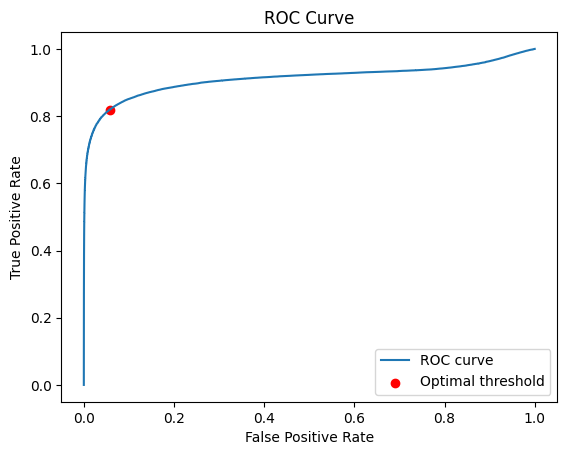

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

y_scores = pred_labels.numpy()
y_true = true_labels.numpy()

fpr, tpr, thresholds = roc_curve(y_true.ravel(), y_scores.ravel())

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal threshold: {optimal_threshold}')

plt.plot(fpr, tpr, label='ROC curve')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', marker='o', label='Optimal threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

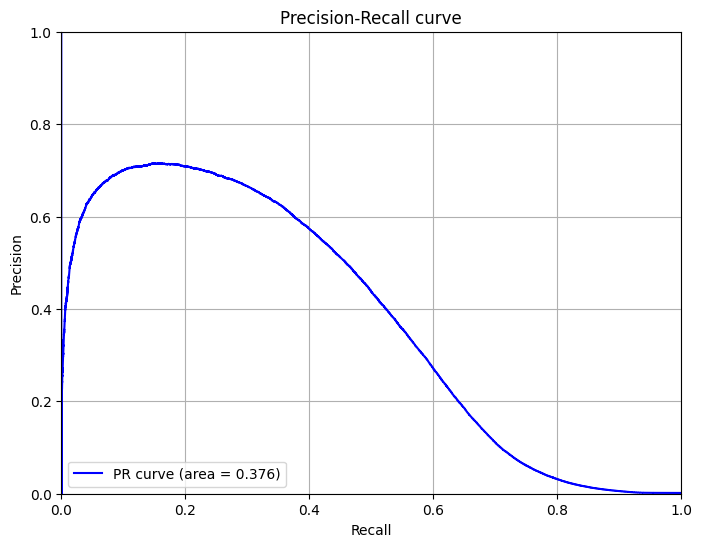

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_true = true_labels.numpy().ravel()

y_scores = pred_labels.numpy().ravel()

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

average_precision = average_precision_score(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label='PR curve (area = {:.3f})'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.grid()
plt.legend(loc="lower left")
plt.show()

## Часть 2: предсказание категорий (0.5 балла)

**[0.5 балла] Задание 8:** Возьмите датасет `df_vk` и для всех новостей из него предскажите категории с помощью лучшей, получившейся у вас модели.

In [ ]:
df_vk['target_tags'] = [[0]]*df_vk.shape[0]
df_vk.head()

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,target_tags
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNKN,[0]
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNKN,[0]
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNKN,[0]
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNKN,[0]
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNKN,[0]


In [ ]:
new_dataset = CrazyDataset(
    target=df_vk.target_tags.values,
    title=df_vk.title_clean.values.astype('str').tolist(),
    tokenizer_name=tokenizer,
    max_title_len=MAX_TITLE_LEN,
    max_classes=CLASSES_NUM
)

In [ ]:
vk_predictions = trainer.predict(new_dataset)
pred_labels_vk = torch.tensor(vk_predictions.predictions)
pred_labels_vk

tensor([[-18.9362, -15.8956, -11.1061,  ..., -14.1200, -17.4672, -20.4593],
        [-11.5738, -11.5366, -11.8160,  ...,  -8.8773, -11.6434, -16.1132],
        [-12.7038, -13.7845,  -9.0873,  ..., -11.6317, -12.5654, -12.9288],
        ...,
        [ -9.0480, -11.6633,  -8.5185,  ...,  -8.8444, -14.3294,  -9.8860],
        [-13.0625, -14.4709, -10.1114,  ..., -13.9576, -16.4467, -11.3766],
        [ -9.5765, -12.2056,  -7.4711,  ..., -11.8101, -21.4595,  -9.1296]])

In [ ]:
binary_pred_labels_vk = binarize_predictions(pred_labels_vk)
binary_pred_labels_vk.shape

torch.Size([19928, 1583])

In [ ]:
predicted_classes = []
for row in binary_pred_labels_vk:
    classes_for_object = np.where(row == 1)[0].tolist() # Находим индексы, где значение равно 1
    predicted_classes.append(classes_for_object)

In [ ]:
df_vk['target_tags'] = predicted_classes
df_vk

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,target_tags
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNKN,"[186, 421, 465, 750]"
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNKN,"[185, 1555]"
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNKN,[186]
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNKN,"[186, 1396]"
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNKN,"[873, 1375]"
...,...,...,...,...,...,...,...,...,...,...
19923,17976905,/politics/20170929/1505812885.html,2017-09-29 03:51:03,"Политологи назвали губернаторов, которым грози...",141,114,NaN,политологи назвали губернаторов которым грозит...,#UNKN,"[1245, 1454]"
19924,17976766,/politics/20170929/1505809314.html,2017-09-29 03:20:41,"Захарова рассказала, какую книгу подписывал Ла...",140,50,NaN,захарова рассказала какую книгу подписывал лав...,#UNKN,"[186, 969, 1245]"
19925,17976601,/science/20170928/1505787196.html,2017-09-29 02:55:49,Современные люди появились более 300 тысяч лет...,202,69,NaN,современные люди появились более 300 тысяч лет...,#UNKN,[1245]
19926,17976198,/world/20170929/1505810992.html,2017-09-29 02:00:09,В США ребенок устроил стрельбу,138,51,NaN,в сша ребенок устроил стрельбу,#UNKN,"[186, 1396]"


На всякий случай сохраните табличку с получившимися у вас предсказаниями. Мало ли, вы не доделаете последнее задание, а потом захотите вернуться к нему. Не прогонять же обучение нейросети и инференс по второму кругу...

In [ ]:
df_vk.to_pickle('scored_vk_df.pkl')

## Часть 3: сентимент-классификатор (1.5 балла)

В этой части тетрадки нам предстоит прогнать все комментарии из ВК через сентимент-классификатор. Мы будем делать это с помощью библиотеки HuggingFace. В ней есть удобная [функциональность pipline,](https://huggingface.co/docs/transformers/pipeline_tutorial) чтобы прогонять на своих данных уже обученные модели. 🤗🤗🤗

In [ ]:
df_comments.head()

,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


**[1.5 балла] Задание 9:** Для классификации комментариев на позитивные, негативные и нейтральные будем использовать [модель, о которой можно почитать по ссылке](https://huggingface.co/seara/rubert-tiny2-russian-sentiment)

Ответьте на следующие вопросы:

1. Как зовут автора модели? Описание упоминает репозиторий GitHub S. Smetanin, который, вероятно, является автором или владельцем проекта??

2. Как выглядит архитектура модели? Насколько модель большая? Архитектура модели — RuBERT-tiny2. Это указывает на то, что модель основана на архитектуре RuBERT, но это её уменьшенная ("tiny2") версия. Это означает, что модель меньше, чем RuBERT-base или RuBERT-large

3. На каких данных обучена модель? Адекватно ли использовать её для классификации комментариев ВК?

Модель обучена на объединённом наборе данных, включающем: Kaggle Russian News Dataset, Linis Crowd 2015, Linis Crowd 2016, RuReviews, RuSentiment

Модель обучена на текстах на русском языке и настроена на задачу анализа настроений, плюс она подходит для коротких текстов => комментарии в вк соответуствуют.

Установим библиотеку. 🤗🤗🤗

In [ ]:
!pip3 install transformers

**Варнинг:** в этом задании не обязательно ждать, пока код проскорит весь датасет - это долго. Напишите код, проверьте, что он корректно работает - проскорьте пару десятков строк датасета и принтаните их. Дальше вы можете взять уже проскоренный датасет. Возможно, кто-то проскорит все раньше остальных и захочет поделиться результатом. Вот его разрешается взять, как готовый результат выполнения задания. Главное - покажите, что ваш код тоже работает.

Разберитесь как можно прогнать модель на корпусе комментариев и сделайте это. Да, с помощью pipeline можно запустить довольно сложные модели, обученные другими людьми в пару строчек. При объявлении модели не забудьте положить её на нужный `device` 🤗🤗🤗

In [ ]:
from transformers import pipeline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = pipeline(
    model="seara/rubert-tiny2-russian-sentiment",
    device=device,
    tokenizer="seara/rubert-tiny2-russian-sentiment",
    max_length=2040,
    truncation=True
)

def classify_sentiment(comment):
    result = model(comment)[0]
    return result['label'], result['score']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Цикл для сентимент-анализа комментариев может работать довольно долго. Я крайне рекомендую вам переодически сохранять к себе на компьютер промежуточные результаты. Итоговый результат я рекомендую записать отдельным столбиком в таблицу с комментариями, а затем сохранить полученные результаты. 🤗🤗🤗

In [ ]:
df_comments_samp = df_comments.sample(frac=0.1) # возьмем 10% данных

df_comments_samp[['sentiment_verdict', 'sentiment_score']] = df_comments_samp['text'].apply(classify_sentiment).apply(pd.Series)

df_comments_samp

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score
754490,22622448,22622323.0,2018-10-09 13:46:56,"[id192350681|Tory], вафел ты походу",0.0,neutral,0.851502
1178437,21832148,21831475.0,2018-08-02 12:34:08,"[id273706582|Лизавета], тоже верно. Хотя вы по...",0.0,neutral,0.591847
1289752,21624338,21623575.0,2018-07-15 04:10:05,Надо вместо Грефа тамагочи поставить . И то бо...,4.0,neutral,0.820133
2350258,18973025,18971599.0,2017-12-20 10:36:41,Погутарили через а ну не в этом деле а при Ста...,0.0,neutral,0.534671
841422,22464670,22463643.0,2018-09-26 07:52:23,"[id249908308|Евгений], а что плохого ?",0.0,neutral,0.600503
...,...,...,...,...,...,...,...
2569683,18336678,18334121.0,2017-10-30 06:04:48,"[id401775587|Leka], ""нибольна никем"", это уже ...",0.0,neutral,0.714328
743013,22647659,22642799.0,2018-10-11 11:03:25,"Кто против , того к стенке.",0.0,neutral,0.873791
1892994,20293408,20291161.0,2018-04-02 01:40:57,Респект и уважуха!!!,2.0,positive,0.994043
2548854,18390094,18390043.0,2017-11-03 15:54:29,"Хай зарабатывает, мне не жалко. Удачи ему",2.0,neutral,0.447906


In [ ]:
df_vk.to_csv('vk.csv', index=False)
df_comments_samp.to_csv('comments_with_sentiment.csv', index=False)

In [ ]:
df_comments_samp[df_comments_samp['sentiment_verdict'] == 'positive']['text'].values[:10] # ну не сказать прям что безумно позитивно, но допустим

array(['[id494779097|Роман], опять же, дом Европейской отделки, очень красиво выглядит',
       'Острова наши🇷🇺🇷🇺🇷🇺✊🏼✊🏼✊🏼',
       '[id243646286|Егор], )))хорошо,не положим туда!))поменем лучшим коньяком!))и молва будет добрая,обещаю!))😃😃👍',
       'В принципе я ***её принципы.',
       'Режим самоуничтожения-включен, прощай Ксюха👋',
       'Одно и тоже каждый год ))))) удачи вам Россия. Держитесь еще 6 лет, ссори',
       'По 14 р за кг.',
       '[id129390508|Пётр], и богу тоже. психологическая поддержка и с батюшками иной раз можно весьма плодотворно потолковать, у них все местные в приходе.',
       'Упокой Господь души погибших и скорейшего выздоровления пострадавшим хочется пожелать',
       '[id154804402|Людмила], приятно читать такие новости. Уверен,со строительством железнодорожного моста до вас, дела пойдут еще быстрее в гору. Удачи вам!'],
      dtype=object)

## Часть 4: аналитика (3 балла + 0.2 бонусных)

Мы с вами огромные молодцы. Мы обучили модель для категоризации новостей, построили с её помощью прогнозы. Мы проскорили комментарии на их сентимент-окрас. Теперь давайте проанализируем новости. Описывайте полученные результаты таким образом, чтобы не получить уголовку на 5 лет за дискредитацию чего-нибудь или оскорбление чувств кого-нибудь 💜

__[0.6 балла] Задание 10:__ Какая доля комментариев позитивная? Какая доля комментариев негативная? Выведите 10 самых позитивных комментариев.

Выведите 10 самых негативных комментариев, поугарайте с них. Удалите их вывод из тетрадки. Никто не должен их видеть, это должно остаться только между нами. Поззитивные не удаляйте. Они пусть останутся.

In [54]:
# будем использовать датасет добрых людей из чата

url = 'https://github.com/aeksin/datasets/releases/download/new12/df_comments.csv'
df = pd.read_csv(url)
df

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0,positive,0.676261
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223
...,...,...,...,...,...,...,...
2612624,17991829.0,17976037.0,2017-09-30 10:27:11,"Сергей, я про простых американцев, которые слу...",0.0,neutral,0.649754
2612625,17992004.0,17976037.0,2017-09-30 10:49:21,"[id415883695|Евгений], у них довольствие и они...",0.0,negative,0.697936
2612626,17992058.0,17976037.0,2017-09-30 10:56:29,"[id142882974|Сергей], ну Кадафи и Хусейныча он...",0.0,negative,0.623313
2612627,17992487.0,17976037.0,2017-09-30 11:56:03,"[id142882974|Сергей], для этого существует физ...",0.0,neutral,0.873600


In [55]:
# доля позитивных - 0.06, доля негативных - 0.23
sentiments_info = df.sentiment_verdict.value_counts().reset_index()
sentiments_info['fractions'] = sentiments_info['count'] / sentiments_info['count'].sum()
sentiments_info

,sentiment_verdict,count,fractions
0,neutral,1826749,0.699200
1,negative,597766,0.228799
2,positive,188114,0.072002


In [56]:
# 10 самых позитивных
df[df['sentiment_verdict'] == 'positive'].sort_values(by='sentiment_score', ascending=False).head(10) # Отлично!

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score
493792,23095070.0,23094261.0,2018-11-17 11:21:56,"Отлично, молодец!Поздравляю!✨💫🌟💥",0.0,positive,0.996725
1379447,21323499.0,21322970.0,2018-06-20 18:54:40,Отлично! Просто отлично! Молодцы! Поздравляю о...,3.0,positive,0.996674
2352264,18718201.0,18718179.0,2017-11-30 13:22:42,"отлично,молодцы!!!👍 респект",3.0,positive,0.996605
2057938,19643844.0,19640879.0,2018-02-16 08:33:19,Отлично! \nПоздравляем!!!,1.0,positive,0.996536
2074701,19591344.0,19588477.0,2018-02-12 08:25:08,"Отлично,я рад.",0.0,positive,0.996462
236794,23585686.0,23584622.0,2018-12-29 11:48:39,"Отлично,молодцы",2.0,positive,0.996461
1300899,21515168.0,21514312.0,2018-07-06 15:22:04,"Отлично,люблю ездить в Эмираты",0.0,positive,0.996450
288287,23487341.0,23487299.0,2018-12-20 12:34:50,Отлично! Здоровья всем желаю!,8.0,positive,0.996444
411428,23248899.0,23242108.0,2018-11-30 07:31:37,Я очень счастлива! Поздравляю!,0.0,positive,0.996431
1681663,20633834.0,20633609.0,2018-04-25 10:13:42,"Отлично, просто отлично!",0.0,positive,0.996418


In [ ]:
# 10 самых негативных
df[df['sentiment_verdict'] == 'negative'].sort_values(by='sentiment_score', ascending=False).head(10)

In [ ]:
# посмотрим на негативные внимательнее (строго научый интерес)

df[df['sentiment_verdict'] == 'negative'].sort_values(by='sentiment_score', ascending=False).head(10)['text'].values

Очень любопытно конечно, а самое главное вообще не позитивно

__[0.6 балла] Задание 11:__ Для каждой новости из датасета посчитайте количество негативных и позитивных комментариев под ней. Сохраните эти количества в виде новых колонок.

In [59]:
comments_num = pd.pivot_table(data=df, values='id', index='post_id', columns='sentiment_verdict', aggfunc='count').rename_axis(None, axis=1).reset_index().fillna(0).astype(int)
comments_num

,post_id,negative,neutral,positive
0,17976037,57,169,12
1,17976198,10,40,1
2,17976601,11,56,0
3,17976766,11,29,8
4,17976905,31,77,4
...,...,...,...,...
19922,24005764,37,93,10
19923,24005972,10,28,2
19924,24006100,4,15,3
19925,24006240,11,28,3


In [60]:
df = df.merge(comments_num, how='left', on='post_id')
df

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score,negative,neutral,positive
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246,10,35,2
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370,10,35,2
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0,positive,0.676261,10,35,2
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939,10,35,2
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223,10,35,2
...,...,...,...,...,...,...,...,...,...,...
2612624,17991829.0,17976037.0,2017-09-30 10:27:11,"Сергей, я про простых американцев, которые слу...",0.0,neutral,0.649754,57,169,12
2612625,17992004.0,17976037.0,2017-09-30 10:49:21,"[id415883695|Евгений], у них довольствие и они...",0.0,negative,0.697936,57,169,12
2612626,17992058.0,17976037.0,2017-09-30 10:56:29,"[id142882974|Сергей], ну Кадафи и Хусейныча он...",0.0,negative,0.623313,57,169,12
2612627,17992487.0,17976037.0,2017-09-30 11:56:03,"[id142882974|Сергей], для этого существует физ...",0.0,neutral,0.873600,57,169,12


__[0.6 балла] Задание 12:__ Правда ли, что новости с большим количеством лайков получают больше негативных комментариев? А позитивных? Правда ли, что чем больше лайков, тем под новостью больше комментариев?

Постройте визуализацию, которая могла бы это проиллюстрировать.

In [61]:
post_likes = df_vk[['id', 'likes', 'comments']].rename(columns={'likes':'post_likes', 'id':'post_id'})
post_likes

,post_id,post_likes,comments
0,24006362,15,28
1,24006240,32,42
2,24006100,84,23
3,24005972,58,35
4,24005764,45,145
...,...,...,...
19923,17976905,141,114
19924,17976766,140,50
19925,17976601,202,69
19926,17976198,138,51


In [62]:
df = df.merge(post_likes, how='left', on='post_id')
df

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score,negative,neutral,positive,post_likes,comments
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246,10,35,2,15,28
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370,10,35,2,15,28
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0,positive,0.676261,10,35,2,15,28
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939,10,35,2,15,28
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223,10,35,2,15,28
...,...,...,...,...,...,...,...,...,...,...,...,...
2612624,17991829.0,17976037.0,2017-09-30 10:27:11,"Сергей, я про простых американцев, которые слу...",0.0,neutral,0.649754,57,169,12,329,241
2612625,17992004.0,17976037.0,2017-09-30 10:49:21,"[id415883695|Евгений], у них довольствие и они...",0.0,negative,0.697936,57,169,12,329,241
2612626,17992058.0,17976037.0,2017-09-30 10:56:29,"[id142882974|Сергей], ну Кадафи и Хусейныча он...",0.0,negative,0.623313,57,169,12,329,241
2612627,17992487.0,17976037.0,2017-09-30 11:56:03,"[id142882974|Сергей], для этого существует физ...",0.0,neutral,0.873600,57,169,12,329,241


In [63]:
posts_with_likes_and_comms = df[['post_id', 'post_likes', 'negative', 'positive', 'neutral']].drop_duplicates()
posts_with_likes_and_comms

,post_id,post_likes,negative,positive,neutral
0,24006362.0,15,10,2,35
47,24006240.0,32,11,3,28
89,24006100.0,84,4,3,15
111,24005972.0,58,10,2,28
151,24005764.0,45,37,10,93
...,...,...,...,...,...
2612113,17976905.0,141,31,4,77
2612225,17976766.0,140,11,8,29
2612273,17976601.0,202,11,0,56
2612340,17976198.0,138,10,1,40


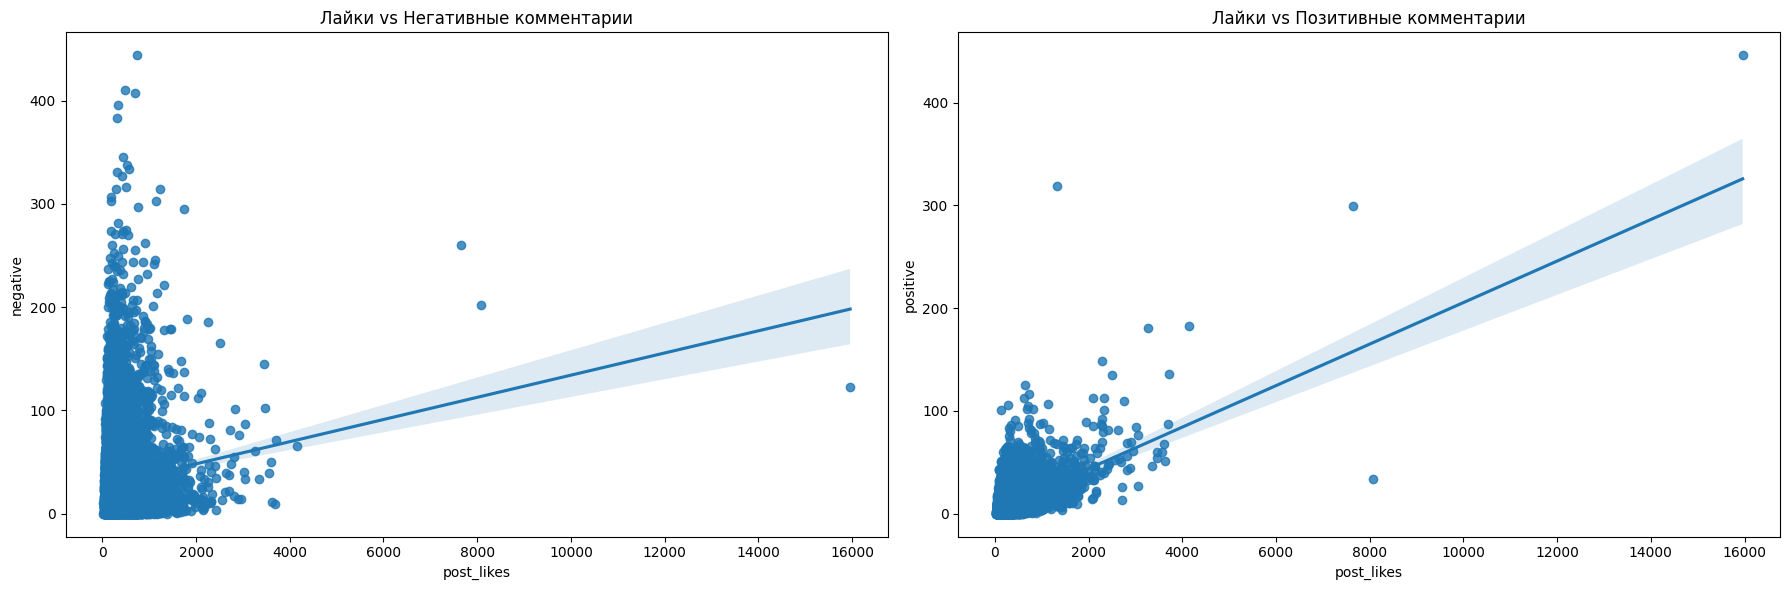

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 ряд, 3 столбца

sns.regplot(x='post_likes', y='negative', data=posts_with_likes_and_comms, ax=axes[0])
axes[0].set_title('Лайки vs Негативные комментарии')

sns.regplot(x='post_likes', y='positive', data=posts_with_likes_and_comms, ax=axes[1])
axes[1].set_title('Лайки vs Позитивные комментарии')

plt.tight_layout()
plt.show()

Что-то не очеь видно, конечно

Разделим новости на 10 группы в зависимости от количество лайков, которые собрала новость (0 - группа с наименьшим числом лайков, 9 - с наибольшим)

In [65]:
posts_with_likes_and_comms['like_group'] = pd.qcut(posts_with_likes_and_comms['post_likes'], q=10, labels=False)
posts_with_likes_and_comms

,post_id,post_likes,negative,positive,neutral,like_group
0,24006362.0,15,10,2,35,0
47,24006240.0,32,11,3,28,0
89,24006100.0,84,4,3,15,0
111,24005972.0,58,10,2,28,0
151,24005764.0,45,37,10,93,0
...,...,...,...,...,...,...
2612113,17976905.0,141,31,4,77,2
2612225,17976766.0,140,11,8,29,2
2612273,17976601.0,202,11,0,56,4
2612340,17976198.0,138,10,1,40,2


В каждой группе будем смотреть среднее число комментариев (позитивных и негативных)

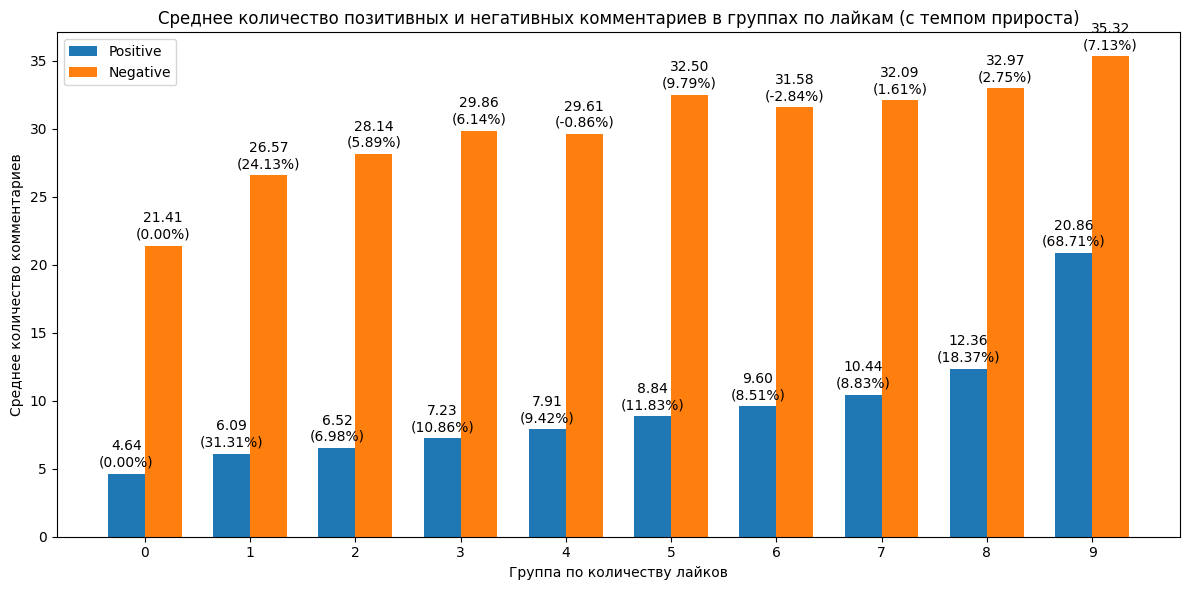

In [66]:
df_grouped = posts_with_likes_and_comms.groupby('like_group')[['positive', 'negative']].mean()

df_grouped['positive_growth'] = df_grouped['positive'].pct_change() * 100
df_grouped['negative_growth'] = df_grouped['negative'].pct_change() * 100
df_grouped.fillna(0, inplace=True)

width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(df_grouped.index - width/2, df_grouped['positive'], width, label='Positive')
rects2 = ax.bar(df_grouped.index + width/2, df_grouped['negative'], width, label='Negative')

def autolabel(rects, growth_column):
    for i, rect in enumerate(rects):
        height = rect.get_height()
        growth = growth_column.iloc[i]
        label = f'{height:.2f}\n({growth:.2f}%)'
        ax.annotate(label,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1, df_grouped['positive_growth'])
autolabel(rects2, df_grouped['negative_growth'])


ax.set_xlabel('Группа по количеству лайков')
ax.set_ylabel('Среднее количество комментариев')
ax.set_title('Среднее количество позитивных и негативных комментариев в группах по лайкам (с темпом прироста)')
ax.legend()
ax.set_xticks(df_grouped.index)

fig.tight_layout()
plt.show()

На этом графике видно:

1) Негативных комментариев в принципе больше позитивных для всех групп

2) С увеличением числа лайков в среднем растет число как позитивных, так и негативных комментариев

3) В относительном выражении с увеличением числа лайков на новости - число позитивных комментариев растет **сильнее**, чем число негативных комментариев

Ну и напоследок посмотрим на корреляцию

In [67]:
correlation_negative = posts_with_likes_and_comms['post_likes'].corr(posts_with_likes_and_comms['negative'])
correlation_positive = posts_with_likes_and_comms['post_likes'].corr(posts_with_likes_and_comms['positive'])

print(f"Корреляция лайки-негативные комментарии: {correlation_negative:.2f}")
print(f"Корреляция лайки-позитивные комментарии: {correlation_positive:.2f}")

Корреляция лайки-негативные комментарии: 0.10
Корреляция лайки-позитивные комментарии: 0.58


Видно, что число позитивных комментариев имеет более сильную корреляцию с числом лайков на новсти, чем негативные комментарии

__[0.6 балла] Задание 13:__  Давайте построим по сентимент-окрасу комментариев топ позитивных новостей.

- Если под новостью оставлено 100 комментариев, из которых 80 позитивные, мы можем быть уверены в том, что новость была хорошо воспринята людьми.
- Если под новостью всего один комментарий и он оказался позитивным, то у нас 100% позитивных комментариев, но это вовсе не означает, что новость была воспринята хорошо.

Получается, что сортировать по доле позитивных комментариев нельзя. Давайте поступим умнее. Доля позитивных комментариев под постом -- это случайная величина. Её довольно часто моделируют с помощью бета-распределения. Если это случайная величина, мы можем построить для неё предиктивный интервал. Пусть $u$ - число позитивных комментариев, а $d$ - нейтральных и негативных.  Пусть

$$
a = 1 + u \qquad b = 1 + d.
$$

Тогда нижняя граница $95\%$ предиктивного интервала для доли будет вычисляться по такой формуле:

$$
\frac{a}{a + b} - 1.65 \cdot \sqrt{\frac{a \cdot b}{(a + b)^2 \cdot (a + b + 1)}}
$$

Если под новостью был всего один комментарий, у такой случайной величины будет высокая дисперсия. Это означаeт, что штука, которую мы вычитаем из доли, окажется высокой. Левая граница интервала окажется маленькой и мы не поднимем комментарий в нашем топе наверх. Фактически мы делаем сортировку по квантилю уровня $0.05$ вместо среднего.

От вас требуется вбить эту формулу, сделать сортировку и вывести на экран топ позитивных новостей. Подробнее про то, откуда берётся эта формула можно почитать [в этой книге.](https://disk.yandex.ru/i/Ctd08bTwC9eI3g) Ищите 4 главу, страницу 140.

In [68]:
posts_with_likes_and_comms

,post_id,post_likes,negative,positive,neutral,like_group
0,24006362.0,15,10,2,35,0
47,24006240.0,32,11,3,28,0
89,24006100.0,84,4,3,15,0
111,24005972.0,58,10,2,28,0
151,24005764.0,45,37,10,93,0
...,...,...,...,...,...,...
2612113,17976905.0,141,31,4,77,2
2612225,17976766.0,140,11,8,29,2
2612273,17976601.0,202,11,0,56,4
2612340,17976198.0,138,10,1,40,2


In [69]:
posts_with_likes_and_comms['a'] = 1 + posts_with_likes_and_comms['positive']
posts_with_likes_and_comms['b'] = 1 + posts_with_likes_and_comms['negative'] + posts_with_likes_and_comms['neutral']

#Вычисление нижней границы 95% предиктивного интервала
posts_with_likes_and_comms['lower_bound'] = (posts_with_likes_and_comms['a'] / (posts_with_likes_and_comms['a'] + posts_with_likes_and_comms['b'])) \
- 1.65 * np.sqrt((posts_with_likes_and_comms['a'] * posts_with_likes_and_comms['b']) / (((posts_with_likes_and_comms['a'] + posts_with_likes_and_comms['b'])**2) \
* (posts_with_likes_and_comms['a'] + posts_with_likes_and_comms['b'] + 1)))

posts_with_likes_and_comms.sort_values('lower_bound', ascending=False).head(10)

,post_id,post_likes,negative,positive,neutral,like_group,a,b,lower_bound
893123,22320852.0,1387,0,34,16,9,35,17,0.566760
1928101,20027260.0,1106,0,16,8,9,17,9,0.502777
1893651,20128079.0,670,0,10,4,9,11,5,0.502010
890436,22326485.0,359,0,10,4,7,11,5,0.502010
1701838,20591225.0,1292,3,42,26,9,43,30,0.494670
1017657,22073093.0,1882,3,59,44,9,60,48,0.477024
645578,22783725.0,983,5,29,15,9,30,21,0.475624
287738,23489272.0,40,0,6,2,0,7,3,0.472020
1394939,21284685.0,713,4,29,17,9,30,22,0.464950
1917660,20065831.0,2429,4,48,36,9,49,41,0.458303


In [87]:
ids = posts_with_likes_and_comms.sort_values('lower_bound', ascending=False).head(10)['post_id']

df_vk[df_vk['id'].isin(ids)]['title']

,title
2133,"Ваши поздравления на елке ""Россия Сегодня"" в ГУМе"
4968,Сборная России вернулась в Москву после победы...
6620,Россиянки заняли третье место в ските среди юн...
6651,Сборная России выиграла командный турнир на че...
7572,"Россиянин Иван Бессонов победил в конкурсе ""кл..."
10348,Сербия обыграла Коста-Рику на ЧМ-2018
12529,"""Ак Барс"" стал трехкратным обладателем Кубка Г..."
13735,Россиянка Мельникова победила в многоборье на ...
13930,Вопреки всему: россияне стали вторыми на Парал...
14020,"Миленина выиграла биатлонную гонку на 12,5 км,..."


Построили? Срочно пришлите свою любимую позитивную  новость в общий чат!!!

Топ негативных новостей строить не будем. Вокруг итак слишком много негатива 😻😻😻

__[0.6 балла] Задание 14:__ Какие категории новостей оказались самыми позитивными? Придумайте способ найти такие категории и опишите его тут.

__Ответ:__ Ну короче. Предлагаю считать долю позитивных комментариев под новостью и затем умножать на число позитивных комментариев под данной новостью и делить на среднее число позитвных комментариев. В виде формул:

$$p_{i} = \text{positive_frac}^{(i)} * \cfrac{\text{total_positive_number}^{(i)}}{\text{average_positive_number}}$$

- $\text{positive_frac}^{(i)}$ - доля позитивных комментариев под новостью $i$


- $\text{total_positive_number}^{(i)}$ - число позитивных комментариев под новостью $i$


- $\text{average_positive_number}$ - среднее число позитивных комментариев под одной новостью.

Таким образом, мы будем оценивать, является ли новость позитивной на основе информации о доле позитивных комментариев под ней. А затем взвешивать эту долю на то, насколько в целом под данной новостью много позитивных комментариев относительно всего датасета. Так мы скорректируем долю на то, насколько ей можно "доверять". Как было в примере выше: "если под новостью оставлено 100 комментариев, из которых 80 позитивные, мы можем быть уверены в том, что новость была хорошо воспринята людьми, но если под новостью всего один комментарий и он оказался позитивным, то у нас 100% позитивных комментариев, но это вовсе не означает, что новость была воспринята хорошо".

Поэтому долю позитивных комментариев для новостей, у которых позитивных комментариев в среднем больше - мы будем корректировать вверх. Для новостей, у которых, в среднем меньше - корректируем вниз.


In [76]:
posts_with_likes_and_comms['total_comms'] = posts_with_likes_and_comms['positive'] + posts_with_likes_and_comms['negative'] + posts_with_likes_and_comms['neutral']
posts_with_likes_and_comms['positive_frac'] = posts_with_likes_and_comms['positive'] / posts_with_likes_and_comms['total_comms']
posts_with_likes_and_comms['positive_confidence'] = posts_with_likes_and_comms['positive_frac'] * posts_with_likes_and_comms['positive'] / posts_with_likes_and_comms['positive'].mean()

In [79]:
posts_with_likes_and_comms.sort_values(by='positive_confidence', ascending=False).head(10)

,post_id,post_likes,negative,positive,neutral,like_group,a,b,lower_bound,total_comms,positive_frac,positive_confidence
2013172,19755641.0,15959,123,446,481,9,447,605,0.399770,1050,0.424762,20.067867
1294187,21530735.0,1326,178,319,543,9,320,722,0.283534,1040,0.306731,10.364989
1329257,21449629.0,3268,61,181,249,9,182,311,0.333343,491,0.368635,7.067999
746357,22590171.0,7652,260,299,864,9,300,1125,0.192713,1423,0.210119,6.655157
1383050,21312534.0,4151,66,183,313,9,184,380,0.293696,562,0.325623,6.312286
2014222,19755204.0,642,48,125,168,9,126,217,0.324460,341,0.366569,4.853851
2013000,19756217.0,3690,9,87,76,9,88,86,0.443387,172,0.505814,4.661556
1178595,21756625.0,2295,72,149,314,9,150,387,0.247413,535,0.278505,4.395817
2021510,19734372.0,2339,19,101,137,9,102,157,0.343825,257,0.392996,4.204656
1247472,21632060.0,2319,40,113,170,9,114,211,0.307159,323,0.349845,4.187696


In [84]:
ids = posts_with_likes_and_comms.sort_values(by='positive_confidence', ascending=False).head(10)['post_id']
df_vk[df_vk['id'].isin(ids)]['title']

,title
5582,Хабиб Нурмагомедов победил Конора Макгрегора и...
8739,"Московские власти собираются изъять участок, г..."
9241,Сборная Франции выиграла чемпионат мира
9552,Хорватия обыграла Россию по пенальти и вышла в...
9809,"Россия вышла в четвертьфинал ЧМ-2018, обыграв ..."
10267,Сборная России обыграла Египет на ЧМ-2018
14750,Форвард сборной России Никита Гусев стал лучши...
14751,Российские хоккеисты победили немцев и завоева...
14752,Сборные России и Германии не выявили победител...
14821,Российские хоккеисты победили чехов и впервые ...


__[0.2 балла] Бонусное задание 3:__ Проанализируйте, как температура комментария (вероятность того, что он негативный) зависит от длины трэда (число комментариев под новостью)? Значима ли эта взаимосвязь? Если вам для проверки этого хочется построить линейную регрессию, не сдерживайтесь.

In [88]:
import statsmodels.api as sm

posts_with_likes_and_comms['temperature'] = posts_with_likes_and_comms['negative'] / posts_with_likes_and_comms['total_comms']

X = posts_with_likes_and_comms['total_comms']
y = posts_with_likes_and_comms['temperature']

X = sm.add_constant(X)

# Построение линейной регрессии
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            temperature   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     1401.
Date:                Wed, 11 Dec 2024   Prob (F-statistic):          2.13e-296
Time:                        18:44:43   Log-Likelihood:                 20961.
No. Observations:               19927   AIC:                        -4.192e+04
Df Residuals:                   19925   BIC:                        -4.190e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1836      0.001    202.270      

Итак, заметим, что коэффициент перед total_comms = 0.0002. Не будем обманываться небольшим значением. Наша объясняющая переменная имеет бОльшую размерность, чем объясняемая, поэтому для приведения предсказания в нужную размерность используется небольшой коэффициент. Интерпретация: при росте числа комментариев на единицу - вероятность негативного окраса растет на 0.0002 (согласно предсказанию модели).

**Значимость**

Можем заметить, что при тестировании гипотезы о равенстве коэффициента перед данным параметров нулю мы получили $\text {p_value} = 0$, что говорит о том, что на любом разумном уровне значимости гипотеза отвергается.

Таким образом, с определенной уверенностью можно утверждать, что модель построенная на данном параметре значима, ровно как и положительная взаимосвязь между темпераурой комментария и длиной трэда.

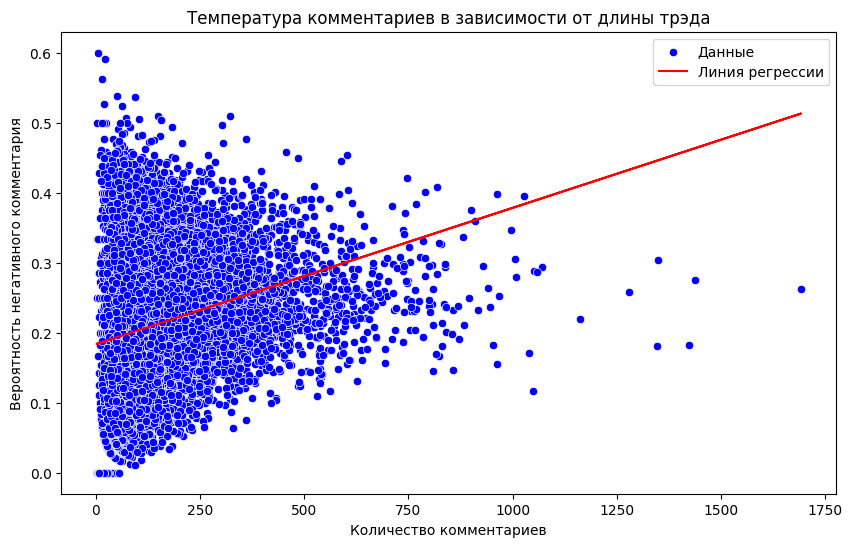

In [92]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=posts_with_likes_and_comms['total_comms'], y=posts_with_likes_and_comms['temperature'], color='blue', label='Данные')
plt.plot(posts_with_likes_and_comms['total_comms'], predictions, color='red', label='Линия регрессии')
plt.title('Температура комментариев в зависимости от длины трэда')
plt.xlabel('Количество комментариев')
plt.ylabel('Вероятность негативного комментария')
plt.legend()
plt.show()